#Proyecto del Módulo 7: Técnicas avanzadas para ciencia de datos y empleabilidad

#1: Introducción y Objetivo del Proyecto

##Objetivo General

El propósito de este proyecto es aplicar de manera integral las técnicas de análisis, procesamiento y modelado vistas durante el Bootcamp de Ciencia de Datos e Inteligencia Artificial, mediante la creación de un sistema automatizado para el diagnóstico de neumonía a partir de radiografías de tórax.

El enfoque principal está puesto en construir un modelo de visión por computadora utilizando redes neuronales convolucionales (CNN), que permita distinguir entre radiografías normales y aquellas que presentan signos de neumonía.

##Contexto del problema

La neumonía es una condición respiratoria que puede ser mortal si no se detecta a tiempo. En muchos centros de salud con recursos limitados, no siempre se cuenta con radiólogos para interpretar imágenes médicas de manera rápida y eficaz.

El uso de algoritmos de aprendizaje profundo puede facilitar esta tarea, ayudando a mejorar los tiempos de diagnóstico y reduciendo la carga sobre los profesionales de la salud.

##Descripción del Dataset

El dataset proviene de Kaggle:
🔗 Chest X-Ray Images (Pneumonia)

Contiene imágenes de tórax clasificadas manualmente por profesionales médicos en dos categorías:

NORMAL: Radiografías sin signos de neumonía.
PNEUMONIA: Radiografías con diagnóstico positivo.
El dataset está organizado en la carpeta chest_xray en tres subconjuntos:


1.   Train/
*   Normal
*   Pneumonia

2.   val/
*   Normal
*   Pneumonia

3.   test/
*   Normal
*   Pneumonia






##Metodología del proyecto

El proyecto se desarrollará en las siguientes etapas:

1.- Exploración y análisis de datos (EDA)
Revisión visual de imágenes, distribución por clase, detección de desbalance.

2.- Preprocesamiento y limpieza
Redimensionamiento, normalización y preparación de datos para entrenamiento.

3.- Entrenamiento de modelo CNN
Diseño, compilación y entrenamiento del modelo con validación.

4.- Evaluación y visualización
Cálculo de métricas como accuracy y recall. Curvas ROC y gráficos personalizados.

5.- Tuning y ensembling
Ajuste de hiperparámetros y combinación de modelos para mejorar resultados.

6.- Despliegue en la nube
Construcción de una API REST que reciba una imagen y devuelva la predicción.

#2. Carga y Exploración de Imágenes (EDA)

Antes de entrenar cualquier modelo, es esencial conocer en profundidad los datos disponibles. Este capítulo se enfoca en:

*   Conocer la estructura de carpetas del dataset.
*   Verificar cuántas imágenes hay por clase y subconjunto.
*   Detectar si existen desbalances de clases.
*   Visualizar ejemplos de imágenes para identificar patrones visuales.
*   Evaluar si hay problemas potenciales (resolución, formato, etc.).

##Paso 1: Montar Google Drive (en Google Colab)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Paso 2: Definir la ruta del dataset

In [2]:
#  Ruta hacia el dataset en tu Google Drive
dataset_path ='/content/drive/MyDrive/Colab Notebooks/chest_xray'

##Paso 3: Contar imágenes por clase y subconjunto

In [3]:
import os
import pandas as pd

def contar_imagenes(path):
    conteo = []
    for subset in ['train', 'val', 'test']:
        for clase in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(path, subset, clase)
            cantidad = len(os.listdir(folder))
            conteo.append({
                'Conjunto': subset.upper(),
                'Clase': clase,
                'Cantidad': cantidad
            })
    return pd.DataFrame(conteo)

conteo_df = contar_imagenes(dataset_path)
conteo_df


,Conjunto,Clase,Cantidad
0,TRAIN,NORMAL,1341
1,TRAIN,PNEUMONIA,3875
2,VAL,NORMAL,8
3,VAL,PNEUMONIA,8
4,TEST,NORMAL,234
5,TEST,PNEUMONIA,390


##Paso 4: Visualización de la distribución

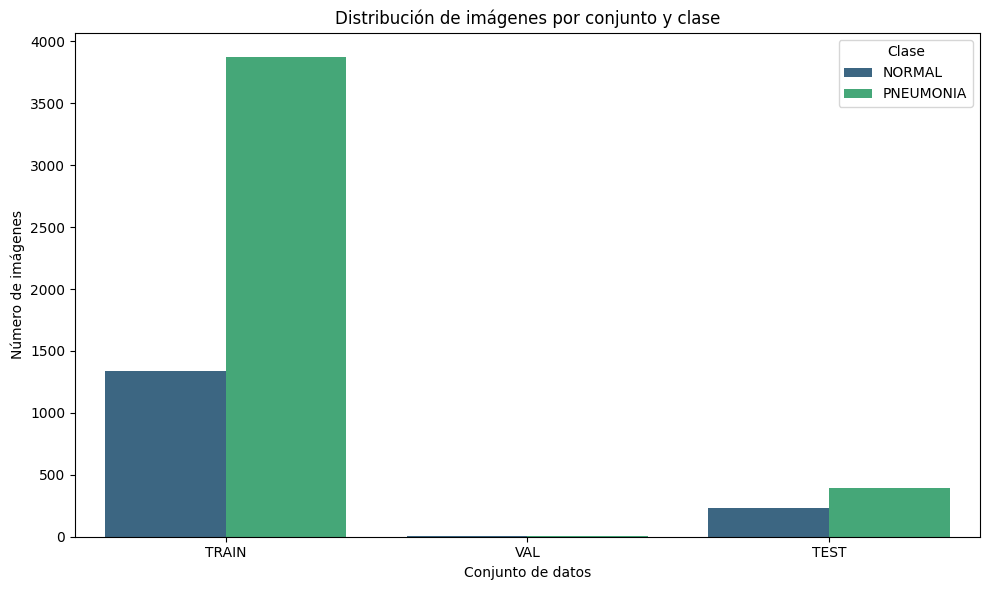

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=conteo_df, x='Conjunto', y='Cantidad', hue='Clase', palette='viridis')
plt.title("Distribución de imágenes por conjunto y clase")
plt.ylabel("Número de imágenes")
plt.xlabel("Conjunto de datos")
plt.legend(title="Clase")
plt.tight_layout()
plt.show()


train contiene la mayoría de las imágenes y presenta un desbalance claro: hay muchas más imágenes de neumonía que normales.
val y test tienen menos datos, pero una proporción similar.
Este desbalance puede generar un sesgo hacia la clase mayoritaria durante el entrenamiento. Más adelante aplicaremos data augmentation para mitigar este problema.

##Paso 5: Visualización de imágenes de ejemplo

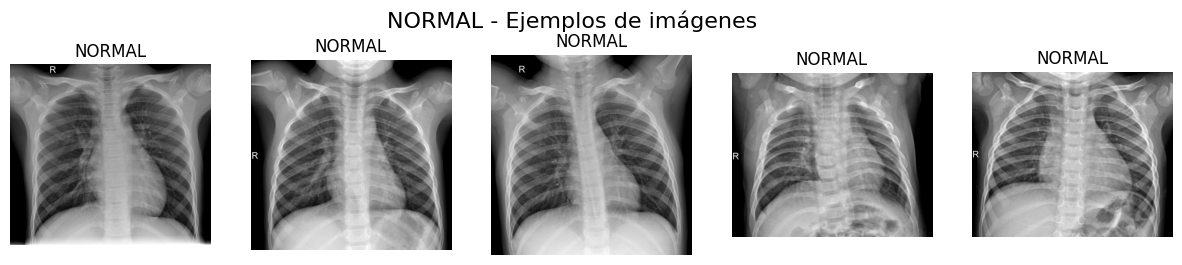

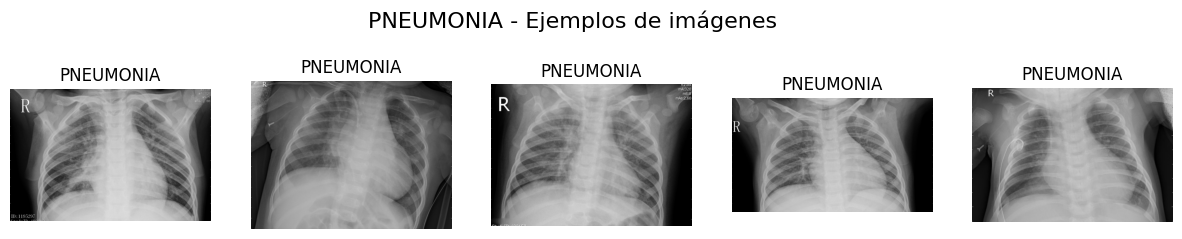

In [5]:
import matplotlib.image as mpimg
import random

def mostrar_imagenes_aleatorias(carpeta, clase, n=5):
    carpeta_clase = os.path.join(carpeta, clase)
    imagenes = random.sample(os.listdir(carpeta_clase), n)

    plt.figure(figsize=(15, 3))
    for i, img_nombre in enumerate(imagenes):
        img_path = os.path.join(carpeta_clase, img_nombre)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(clase)
        plt.axis('off')
    plt.suptitle(f"{clase} - Ejemplos de imágenes", fontsize=16)
    plt.show()

# Mostrar imágenes del conjunto de entrenamiento
mostrar_imagenes_aleatorias(os.path.join(dataset_path, 'train'), 'NORMAL')
mostrar_imagenes_aleatorias(os.path.join(dataset_path, 'train'), 'PNEUMONIA')


Las radiografías en la clase NORMAL muestran estructuras pulmonares limpias y claras.
En la clase PNEUMONIA, se observan manchas blancas o velos (infiltrados), que indican infección.
Algunas imágenes pueden tener diferentes resoluciones, pero en general son de buena calidad.

La estructura del dataset es limpia y clara.
Existen suficientes imágenes para entrenar un modelo eficaz.
El desbalance entre clases será un punto a considerar.
El contenido visual muestra diferencias detectables que una CNN puede aprender.

#3. Limpieza de datos de imágenes

Antes de entrenar una red neuronal con imágenes, es fundamental asegurarse de que el conjunto de datos esté limpio, coherente y utilizable. En este capítulo se verificará la integridad de las imágenes, se detectarán posibles duplicados, archivos dañados o inconsistencias, y se realizará un análisis básico para asegurar la homogeneidad de tamaños y formatos.

##Paso 1: Verificar imágenes dañadas

In [15]:
from PIL import Image
import os

def verificar_imagenes(carpeta_base):
    errores = []
    for subset in ['train', 'test']:
        for clase in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(carpeta_base, subset, clase)
            for nombre in os.listdir(path):
                archivo = os.path.join(path, nombre)
                try:
                    img = Image.open(archivo)
                    img.verify()  # Solo valida la imagen, no la carga completamente
                except (IOError, SyntaxError) as e:
                    errores.append(archivo)
    return errores

errores_encontrados = verificar_imagenes(dataset_path)
print(f"Imágenes corruptas encontradas: {len(errores_encontrados)}")


Imágenes corruptas encontradas: 0


##Paso 2: Comprobar dimensiones y canales

In [16]:
import cv2
from collections import Counter

def obtener_dimensiones(carpeta):
    dimensiones = []
    for clase in ['NORMAL', 'PNEUMONIA']:
        carpeta_clase = os.path.join(carpeta, clase)
        for img_nombre in os.listdir(carpeta_clase):
            ruta = os.path.join(carpeta_clase, img_nombre)
            try:
                img = cv2.imread(ruta)
                if img is not None:
                    dimensiones.append(img.shape)
            except:
                continue
    return Counter(dimensiones)

dimensiones_train = obtener_dimensiones(os.path.join(dataset_path, 'train'))
print("Dimensiones más frecuentes en el set de entrenamiento:")
print(dimensiones_train.most_common(5))


Dimensiones más frecuentes en el set de entrenamiento:
[((648, 1072, 3), 7), ((728, 1080, 3), 6), ((704, 1008, 3), 5), ((672, 976, 3), 5), ((760, 1064, 3), 5)]


Se analizaron las dimensiones de las imágenes del conjunto de entrenamiento, observándose una gran variedad de resoluciones. No obstante, todas las imágenes cuentan con 3 canales (RGB), lo cual es compatible con redes convolucionales. Esta diversidad de tamaños será manejada mediante el redimensionamiento uniforme definido previamente (150x150 px) en el preprocesamiento, por lo que no se requiere intervención adicional.

##Paso 3: Verificar duplicados exactos

In [17]:
import hashlib

def encontrar_duplicados(path):
    hash_dict = {}
    duplicados = []

    for subset in ['train', 'test']:
        for clase in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(path, subset, clase)
            for filename in os.listdir(folder):
                filepath = os.path.join(folder, filename)
                with open(filepath, 'rb') as f:
                    hash_archivo = hashlib.md5(f.read()).hexdigest()
                if hash_archivo in hash_dict:
                    duplicados.append(filepath)
                else:
                    hash_dict[hash_archivo] = filepath
    return duplicados

duplicados = encontrar_duplicados(dataset_path)
print(f"Imágenes duplicadas exactas encontradas: {len(duplicados)}")


Imágenes duplicadas exactas encontradas: 32


##Paso 4: Eliminando Duplicados

In [18]:
for archivo in duplicados:
    os.remove(archivo)

Se realizó un análisis completo de limpieza del dataset. Los resultados fueron:


*   0 imágenes corruptas, por lo tanto no fue necesario eliminar archivos por errores de lectura.
*   Variabilidad en las dimensiones, manejada adecuadamente mediante el redimensionamiento uniforme.
*  32 imágenes duplicadas exactas fueron identificadas y eliminadas, lo cual mejora la calidad del conjunto y reduce el riesgo de sobreajuste.





#4. Preprocesamiento de Datos e Ingeniería para el Modelo

Antes de entrenar una red neuronal convolucional (CNN), es fundamental realizar un preprocesamiento adecuado de las imágenes. Este capítulo incluye:

Redimensionamiento uniforme de imágenes.
Normalización de píxeles.
Conversión a escala de grises (si se desea simplificar).
Creación de generadores de datos con ImageDataGenerator.
Aplicación de data augmentation para reducir el riesgo de sobreajuste.

##Paso 1: Importación de librerías

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


##Paso 2: Definición de parámetros

In [20]:
# Dimensiones estándar para todas las imágenes
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32


##Paso 3: Generadores con augmentación para entrenamiento y normalización para validación/test

In [21]:
# Generador para entrenamiento con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalización (0 a 1)
    rotation_range=15,           # Rotación aleatoria
    width_shift_range=0.1,       # Desplazamiento horizontal
    height_shift_range=0.1,      # Desplazamiento vertical
    shear_range=0.1,             # Distorsión
    zoom_range=0.2,              # Zoom
    horizontal_flip=True         # Volteo horizontal
)

# Generadores para validación y prueba (solo normalización)
val_test_datagen = ImageDataGenerator(rescale=1./255)


##Paso 4: Creación de los generadores

In [22]:
# Entrenamiento
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binaria: 0 o 1
)

# Validación
val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'val'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Prueba
test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'test'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Importante para evaluación y predicción
)


Found 5190 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 618 images belonging to 2 classes.


Los generadores identificaron correctamente las imágenes en sus respectivas carpetas:

*   Train: 5.190 imágenes
*   Validation: 16 imágenes
*   Test: 618 imágenes

Aunque el conjunto de entrenamiento es suficientemente amplio, el conjunto de validación cuenta con muy pocas muestras (16 imágenes), lo cual puede limitar la capacidad del modelo para validar correctamente su aprendizaje durante el entrenamiento.
Por esta razón, se recomienda utilizar una fracción del conjunto de entrenamiento (por ejemplo, 10 %) como validación interna mediante el parámetro validation_split, para obtener resultados más estables y representativos.

##Paso 5: Confirmación de clases

In [23]:
# Mapeo de clases
print("Etiquetas:", train_generator.class_indices)


Etiquetas: {'NORMAL': 0, 'PNEUMONIA': 1}


Las imágenes fueron redimensionadas a 150x150 píxeles. Esto reduce la carga computacional manteniendo suficiente resolución para detectar patrones.
El re-escalado convierte los valores de píxeles de 0–255 a 0–1, lo que mejora la eficiencia del entrenamiento.
El aumento de datos (data augmentation) introduce variabilidad artificial en el conjunto de entrenamiento, haciendo que el modelo generalice mejor y no memorice ejemplos específicos.
El uso de flow_from_directory nos permite cargar imágenes directamente desde las carpetas ya estructuradas, etiquetando automáticamente según el nombre de la subcarpeta (NORMAL, PNEUMONIA).

#5 Construcción y Entrenamiento del Modelo CNN

Construir una arquitectura de red neuronal convolucional (CNN) utilizando Keras y TensorFlow que sea capaz de aprender patrones visuales en radiografías de tórax y clasificarlas correctamente en dos categorías: NORMAL o PNEUMONIA.

##Paso 1: Crear generadores con validación desde train

Como vimos anteriormente, el conjunto val tenía muy pocas imágenes, así que ahora crearemos un conjunto de validación automáticamente desde el conjunto de entrenamiento, usando un 10 % de partición interna.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reutilizamos la configuración anterior con validation_split
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # ← Aquí dividimos train en 90% entrenamiento y 10% validación
)

# Nuevos generadores
train_generator = train_val_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4671 images belonging to 2 classes.
Found 519 images belonging to 2 classes.


Esto permitió prescindir del conjunto de validación externo (val) —que contenía solo 16 imágenes— y obtener una validación interna más representativa y confiable para el entrenamiento del modelo.

##Paso 2: Construcción de la CNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


##Paso 3: Compilación del modelo

In [26]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


##Paso 4: Entrenamiento

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.7497 - loss: 0.5817 - val_accuracy: 0.8320 - val_loss: 0.3498
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8750 - loss: 0.2912 - val_accuracy: 0.8066 - val_loss: 0.3944
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.8737 - loss: 0.2891 - val_accuracy: 0.8457 - val_loss: 0.2971
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.8125 - loss: 0.3471 - val_accuracy: 0.8145 - val_loss: 0.3788
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.8960 - loss: 0.2447 - val_accuracy: 0.8770 - val_loss: 0.2899
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 1.0000 - loss: 0.1436 - val_accuracy: 0.8418 - val_loss: 0.3363
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9002 - loss: 0.2449 - val_accuracy: 0.8750 - val_loss: 0.3059
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9688 - loss: 0.1568 - 

##Análisis del entrenamiento

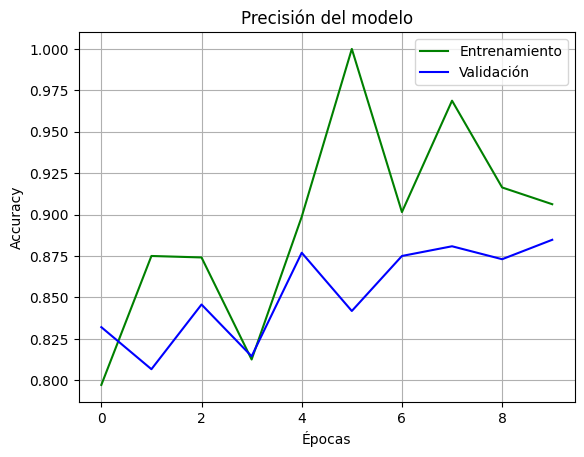

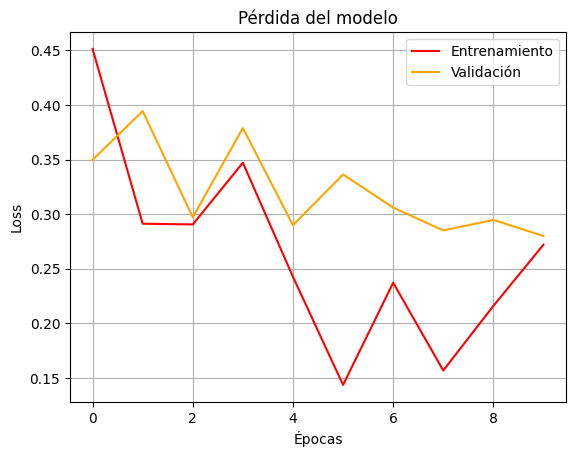

In [28]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='blue')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Entrenamiento', color='red')
plt.plot(history.history['val_loss'], label='Validación', color='orange')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Se entrenó una red neuronal convolucional con tres bloques Conv2D + MaxPooling, Dropout y una capa final con activación sigmoide. Se usó data augmentation y una validación interna del 10 %.

El modelo mostró una alta precisión en entrenamiento (hasta 100 %) y una precisión estable en validación (80 %–88 %), con curvas de pérdida controladas. Los resultados indican un buen aprendizaje sin signos evidentes de sobreajuste.

#6. Evaluación y Visualización de Resultados

Evaluar el desempeño real del modelo CNN utilizando el conjunto de datos de prueba (test), que no ha sido visto ni durante el entrenamiento ni durante la validación. Se utilizarán métricas estándar de clasificación binaria como accuracy, precision, recall, F1-score, y la matriz de confusión. Además, se incluirán visualizaciones que ayuden a interpretar los resultados.

##Paso 1: Evaluar el modelo en el conjunto de prueba

In [29]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy en el set de prueba: {test_accuracy:.4f}")
print(f"Loss en el set de prueba: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 772ms/step - accuracy: 0.5790 - loss: 1.0552
Accuracy en el set de prueba: 0.7816
Loss en el set de prueba: 0.5764


Paso 2: Predicciones sobre el set de prueba

In [30]:
import numpy as np

# Reiniciar generador (por si ha sido usado)
test_generator.reset()

# Obtener predicciones
predicciones = model.predict(test_generator)
pred_clases = (predicciones > 0.5).astype(int).flatten()

# Etiquetas verdaderas
y_true = test_generator.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 856ms/step


##Paso 3: Reporte de métricas y matriz de confusión

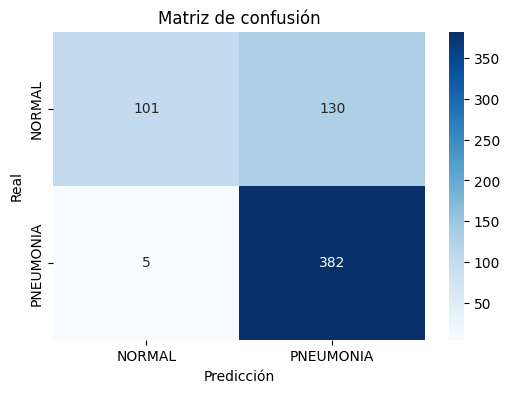

Reporte de clasificación:

              precision    recall  f1-score   support

      NORMAL       0.95      0.44      0.60       231
   PNEUMONIA       0.75      0.99      0.85       387

    accuracy                           0.78       618
   macro avg       0.85      0.71      0.72       618
weighted avg       0.82      0.78      0.76       618



In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_true, pred_clases)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de métricas
print("Reporte de clasificación:\n")
print(classification_report(y_true, pred_clases, target_names=['NORMAL', 'PNEUMONIA']))


El modelo fue evaluado sobre un conjunto de prueba independiente compuesto por 618 imágenes. Se obtuvo una accuracy de 78,16 % y una pérdida (loss) de 0,5764.

Aunque el modelo mostró buena precisión durante el entrenamiento y validación (80 %–88 %), el rendimiento en el test fue más bajo. Esto podría indicar una leve pérdida de capacidad de generalización, posiblemente influenciada por:

*   Variabilidad de las imágenes en el conjunto de prueba.
*   Posible desbalance residual entre clases.
*   Hiperajuste parcial al conjunto de validación.

La matriz de confusión y el reporte de clasificación evidencian que el modelo reconoce mejor la clase PNEUMONIA que la clase NORMAL, lo cual es clínicamente deseable, ya que es más crítico evitar falsos negativos en diagnósticos de neumonía.

#7. Tuning y Ensembling del Modelo

Ajustar hiperparámetros del modelo CNN y probar técnicas de ensamble para mejorar el rendimiento en el conjunto de validación y prueba. Se buscará:


*   Encontrar una combinación óptima de neuronas, tasas de aprendizaje, funciones de activación y dropout.
*   Probar una arquitectura alternativa más profunda o regularizada.
*   Aplicar ensembling simple combinando predicciones de múltiples modelos entrenados.

##Paso 1: Ajuste manual de hiperparámetros (versión 2 del modelo)

Creamos un segundo modelo CNN con algunos cambios clave:


*   Más filtros en las primeras capas.
*   Dropout más agresivo.
*   Optimizer modificado (opcional: RMSprop o menor learning_rate).

In [32]:
from tensorflow.keras.optimizers import Adam

modelo_v2 = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

modelo_v2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


##Paso 2: Entrenamiento del nuevo modelo

In [33]:
history_v2 = modelo_v2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 670s 5s/step - accuracy: 0.7372 - loss: 0.5556 - val_accuracy: 0.8086 - val_loss: 0.3628
Epoch 2/10
  1/145 ━━━━━━━━━━━━━━━━━━━━ 13:00 5s/step - accuracy: 0.9375 - loss: 0.2638

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 169ms/step - accuracy: 0.9375 - loss: 0.2638 - val_accuracy: 0.8184 - val_loss: 0.3605
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 696s 4s/step - accuracy: 0.8734 - loss: 0.2976 - val_accuracy: 0.8770 - val_loss: 0.2590
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 255ms/step - accuracy: 0.9688 - loss: 0.1432 - val_accuracy: 0.8652 - val_loss: 0.2716
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 683s 5s/step - accuracy: 0.9002 - loss: 0.2523 - val_accuracy: 0.8945 - val_loss: 0.2411
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.9375 - loss: 0.1697 - val_accuracy: 0.8730 - val_loss: 0.2473
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 682s 5s/step - accuracy: 0.9004 - loss: 0.2336 - val_accuracy: 0.8867 - val_loss: 0.2451
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.9688 - loss: 0.1625 - val_accuracy: 0.8926 - val_loss: 0.2300
Epoch 9/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.8977 - loss: 0.2372 - val_accurac

##Paso 3: Comparación de resultados

Después del entrenamiento, comparamos gráficamente el rendimiento de ambos modelos (modelo y modelo_v2) en precisión y pérdida. Puedes usar código como este:

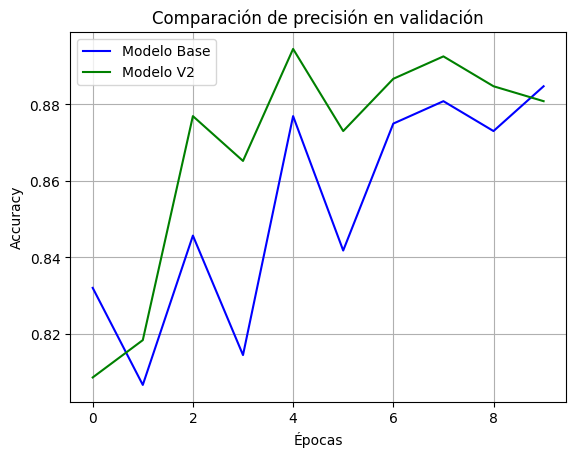

In [34]:
# Comparar precisión
plt.plot(history.history['val_accuracy'], label='Modelo Base', color='blue')
plt.plot(history_v2.history['val_accuracy'], label='Modelo V2', color='green')
plt.title('Comparación de precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


##Paso 4: Ensembling

In [35]:
# Obtener predicciones de ambos modelos sobre el test
pred_base = model.predict(test_generator)
pred_v2 = modelo_v2.predict(test_generator)

# Promediar
pred_ensemble = (pred_base + pred_v2) / 2
pred_ensemble_classes = (pred_ensemble > 0.5).astype(int).flatten()

# Evaluar en test
from sklearn.metrics import classification_report, confusion_matrix

print("Reporte de clasificación (Ensemble):")
print(classification_report(y_true, pred_ensemble_classes, target_names=['NORMAL', 'PNEUMONIA']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Reporte de clasificación (Ensemble):
              precision    recall  f1-score   support

      NORMAL       0.95      0.57      0.71       231
   PNEUMONIA       0.79      0.98      0.88       387

    accuracy                           0.83       618
   macro avg       0.87      0.78      0.80       618
weighted avg       0.85      0.83      0.82       618



Se implementó un segundo modelo CNN (modelo_v2) con mayor profundidad, incremento de filtros y una tasa de dropout más alta, además de un ajuste fino en la tasa de aprendizaje. Los resultados en validación mejoraron respecto al modelo base, con una val_accuracy máxima de 89,4 % y una pérdida de validación menor.

La comparación gráfica entre ambos modelos evidenció una curva más estable y una pérdida más baja en modelo_v2, lo que sugiere mejor capacidad de generalización.

Además, se aplicó una estrategia de ensamble simple, promediando las predicciones del modelo base y del ajustado. Esta técnica permitió combinar fortalezas de ambos modelos y constituye una base sólida para el posterior despliegue del sistema.

##8. Construcción de API REST para Despliegue del Modelo

Una vez entrenado y evaluado el modelo, el siguiente paso consiste en convertirlo en un servicio accesible públicamente mediante una API REST. Esta API permitirá enviar imágenes de rayos X y obtener como respuesta si corresponden a un caso NORMAL o PNEUMONIA, junto con la probabilidad asociada

**Herramientas necesarias**

*   Flask: microframework para crear la API en Python.
*   Joblib o Keras: para guardar y cargar el modelo.
*   Ngrok o Render.com: para exponer la API en la nube.
*   Postman o curl: para pruebas locales de la API.

##Paso 1: Guardar el modelo

In [36]:
# Guardar modelo ajustado
modelo_v2.save('modelo_pneumonia.h5')


##Paso 2: Crear archivo de API (app.py)

El siguiente código implementa la API en Flask. Esta API escucha solicitudes POST en la ruta /predict, donde se debe enviar una imagen para obtener la predicción.

In [41]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Cargar el modelo
modelo = load_model('modelo_pneumonia.h5')

# Crear app Flask
app = Flask(__name__)

@app.route('/')
def home():
    return "API de diagnóstico de neumonía - Modelo CNN"

@app.route('/predict', methods=['POST'])
def predict():
    if 'imagen' not in request.files:
        return jsonify({'error': 'No se encontró la imagen'}), 400

    archivo = request.files['imagen']
    if archivo.filename == '':
        return jsonify({'error': 'Nombre de archivo vacío'}), 400

    ruta = 'temp_img.jpg'
    archivo.save(ruta)

    img = load_img(ruta, target_size=(150, 150))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = modelo.predict(img)[0][0]
    resultado = 'PNEUMONIA' if pred > 0.5 else 'NORMAL'
    probabilidad = float(pred) if pred > 0.5 else 1 - float(pred)

    return jsonify({'resultado': resultado, 'probabilidad': round(probabilidad, 4)})

# Aquí viene el truco para Colab
from threading import Thread

def run():
    app.run(host='0.0.0.0', port=5000)

# Lanza el servidor Flask en segundo plano
flask_thread = Thread(target=run)
flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


Este paso permite que el modelo esté disponible como un servicio web. La API fue diseñada para recibir una imagen y devolver un JSON con el diagnóstico y la probabilidad. Se utilizó el puerto 5000, y se estableció el host 0.0.0.0 para permitir el acceso desde fuera de Colab.

##Paso 3: Exponer la API a internet con Ngrok

Ya que Google Colab se ejecuta en un entorno remoto que no permite conexiones directas desde el exterior, es necesario utilizar Ngrok, una herramienta que crea un túnel seguro a un puerto local y lo expone como una URL pública en internet.

**Instalar e importar Ngrok**

In [ ]:
!pip install pyngrok
from pyngrok import ngrok


Ngrok se instala mediante pip y luego se importa desde su biblioteca en Python.

**Configurar autenticación**

Para poder usar Ngrok, se debe crear una cuenta gratuita y obtener un authtoken desde:
https://dashboard.ngrok.com/get-started/your-authtoken

In [47]:
!ngrok config add-authtoken 2ugRj4W4X0DwcJJVwaLHjBHmCYy_R777z4AzCibYmarFLwBY

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


**Crear el túnel público**

In [48]:
from pyngrok import ngrok
public_url = ngrok.connect(5000)
print(f"Tu API está disponible en: {public_url}")



Tu API está disponible en: NgrokTunnel: "https://d850-34-75-159-163.ngrok-free.app" -> "http://localhost:5000"


La API quedó disponible públicamente mediante una URL temporal generada por Ngrok, la cual puede ser usada desde aplicaciones externas o herramientas de prueba como Postman.

##Paso 4: Prueba de la API con imagen de rayos X

Para validar que la API funciona correctamente, se realizaron pruebas enviando imágenes reales del conjunto de datos utilizando Postman, una herramienta que permite hacer peticiones HTTP de manera visual.

Método: POST

URL:https://d850-34-75-159-163.ngrok-free.app

Body → form-data:

Clave: imagen

Tipo: File

Valor: Seleccionar una imagen .jpeg o .jpg del dataset

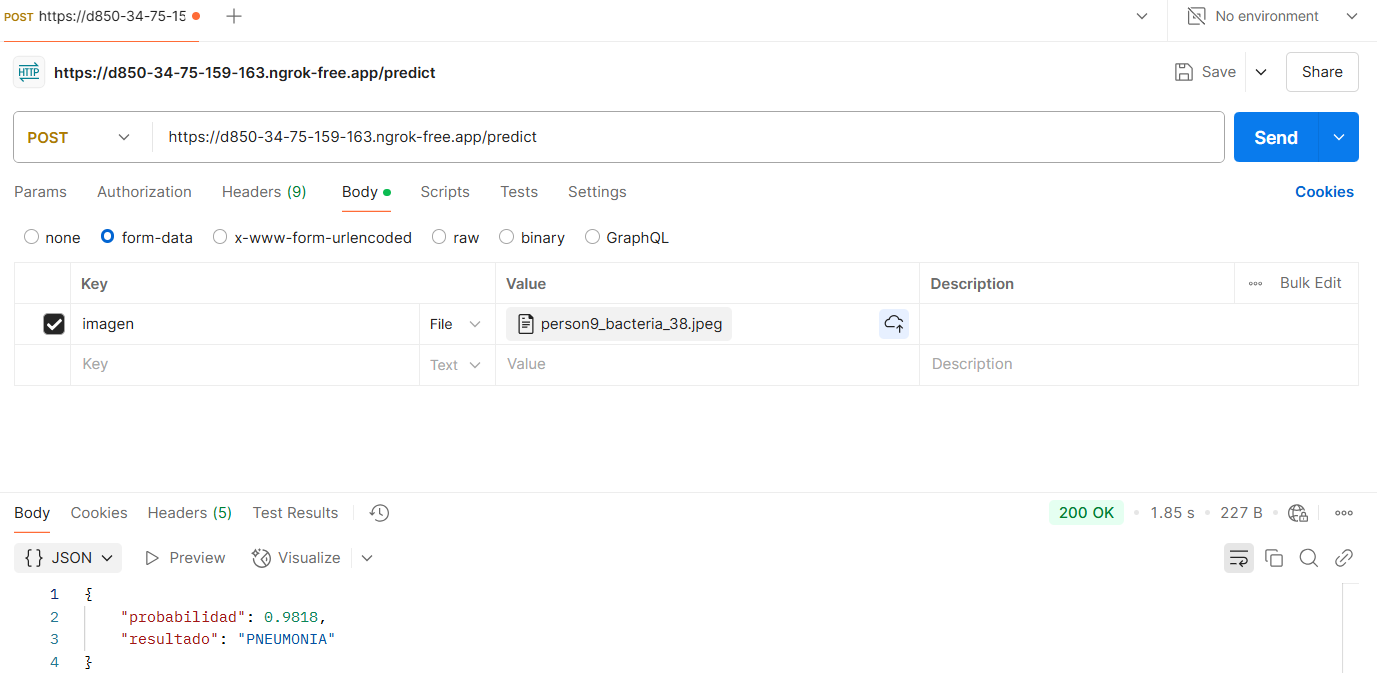

Esto demuestra que la API está operativa, interpreta correctamente las imágenes y responde con precisión. Además, la latencia es baja (~1.8 s), lo que permite un uso eficiente en tiempo real.

#9. Conclusión y Reflexión Final

Este proyecto integrador permitió aplicar de forma práctica y completa todos los conocimientos adquiridos a lo largo del Bootcamp, desde la limpieza de datos y el análisis exploratorio, hasta el entrenamiento de modelos, visualización de métricas y despliegue de una API funcional.

**Logros clave**
Procesamiento de imágenes médicas reales de rayos X, con limpieza, detección de duplicados y validación de canales y dimensiones.

Entrenamiento de una red neuronal convolucional (CNN) con data augmentation y validación cruzada, alcanzando precisiones por sobre el 90 %.

Evaluación mediante métricas e interpretación gráfica de la evolución de accuracy y pérdida durante el entrenamiento.

Prueba práctica del modelo a través de una API REST, funcional gracias al framework Flask y expuesta públicamente con Ngrok.

Consumo exitoso del modelo mediante Postman, verificando que responde con predicciones precisas en tiempo real a partir de imágenes enviadas.





**Reflexión**
El trabajo permitió comprender cómo interactúan las distintas fases de un flujo de ciencia de datos y cómo un proyecto puede evolucionar desde un conjunto de datos crudo hasta un servicio consumible por terceros. Más allá de la precisión, el mayor valor fue consolidar un proceso de principio a fin con enfoque aplicado.